<a href="https://colab.research.google.com/github/shazoop/KG-Embeddings/blob/main/Paper2_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import torch
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import math

In [53]:
def vertex_code(dim, num):
  codebook = np.zeros((num,dim))
  for i in range(num):
    code = np.random.multivariate_normal(np.zeros(dim),np.eye(dim))
    code = code/np.linalg.norm(code)
    codebook[i] = code
  return(codebook)

def vertex_code_R(dim, num):
  codebook = np.zeros((num,dim))
  for i in range(num):
    code = 2*np.random.binomial(1,.5,dim)-1
    codebook[i] = code
  return(codebook)

In [54]:
def generate_edge(special_code):
  edge = np.einsum('i,j -> ij', special_code[0], special_code[1])
  return(edge)

def generate_edge_R(special_code):
  edge = special_code[0]*special_code[1]
  return(edge)

In [99]:
def generate_graph(codebook, num_edges):
  n,d = codebook.shape[0], codebook.shape[1]
  graph = 0
  for i in range(num_edges):
    d_ix, c_ix = rand.randint(0,n-1), rand.randint(0,n-1)
    dom, cod = codebook[d_ix], codebook[c_ix]
    graph  = graph + np.einsum('i,j -> ij', dom, cod)
  return(graph)

def generate_graph_R(codebook, num_edges):
  n,d = codebook.shape[0], codebook.shape[1]
  graph = 0
  for i in range(num_edges):
    d_ix, c_ix = rand.randint(0,n-1), rand.randint(0,n-1)
    dom, cod = codebook[d_ix], codebook[c_ix]
    graph  = graph + (dom*cod)
  return(graph)


In [56]:
def correct_edgeQ(codebook, special_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph(codebook,num_edges) + generate_edge(special_code)
    edgeQ = np.einsum('i,ij,j ->',special_code[0],curr_graph, special_code[1])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

def correct_edgeQ_R(codebook, special_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph_R(codebook,num_edges) + generate_edge_R(special_code)
    edgeQ = np.sum(curr_graph*special_code[0]*special_code[1])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

In [57]:
def incorrect_edgeQ(codebook, special_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph(codebook,num_edges)
    edgeQ = np.einsum('i,ij,j ->',special_code[0],curr_graph, special_code[1])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

def incorrect_edgeQ_R(codebook, special_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph_R(codebook,num_edges)
    edgeQ = np.sum(curr_graph*special_code[0]*special_code[1])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

In [58]:
def edge_composition(graph1,graph2):
  composed_graph = np.einsum('ij,jk -> ik',graph1,graph2)
  return(composed_graph)

def correct_compQ(codebook, edge_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph(codebook,num_edges) + generate_edge(edge_code[:2]) + generate_edge(edge_code[1:3])
    curr_graph = edge_composition(curr_graph,curr_graph)
    edgeQ = np.einsum('i,ij,j ->',edge_code[0],curr_graph, edge_code[2])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

def incorrect_compQ(codebook, edge_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph(codebook,num_edges)
    curr_graph = edge_composition(curr_graph,curr_graph)
    edgeQ = np.einsum('i,ij,j ->',edge_code[0],curr_graph, edge_code[2])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

def edge_composition_R(graph1,graph2):
  composed_graph = graph1*graph2
  return(composed_graph)

def correct_compQ_R(codebook, edge_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph_R(codebook,num_edges) + generate_edge_R(edge_code[:2]) + generate_edge_R(edge_code[1:3])
    curr_graph = edge_composition_R(curr_graph,curr_graph)
    edgeQ = np.sum(edge_code[0]*curr_graph*edge_code[2])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

def incorrect_compQ_R(codebook, edge_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph_R(codebook,num_edges)
    curr_graph = edge_composition_R(curr_graph,curr_graph)
    edgeQ = np.sum(edge_code[0]*curr_graph*edge_code[2])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

In [66]:
def testing(vertex_dim, vertex_num, edge_list, num_trials):
  codebook = vertex_code(vertex_dim,vertex_num)
  special_code = vertex_code(vertex_dim,2)
  edge_code = vertex_code(vertex_dim,3)
  cor_edgeQ = []
  incor_edgeQ = []
  cor_compQ = []
  incor_compQ = []
  for num_edge in edge_list:
    cor_edgeQ.append(correct_edgeQ(codebook, special_code, num_edge, num_trials))
    incor_edgeQ.append(incorrect_edgeQ(codebook, special_code, num_edge, num_trials))
    cor_compQ.append(correct_compQ(codebook, edge_code, num_edge, num_trials))
    incor_compQ.append(incorrect_compQ(codebook, edge_code, num_edge, num_trials))
  return cor_edgeQ, incor_edgeQ, cor_compQ, incor_compQ

def testing_R(vertex_dim, vertex_num, edge_list, num_trials):
  codebook = vertex_code_R(vertex_dim,vertex_num)
  special_code = vertex_code_R(vertex_dim,2)
  edge_code = vertex_code_R(vertex_dim,3)
  cor_edgeQ = []
  incor_edgeQ = []
  cor_compQ = []
  incor_compQ = []
  for num_edge in edge_list:
    cor_edgeQ.append(correct_edgeQ_R(codebook, special_code, num_edge, num_trials))
    incor_edgeQ.append(incorrect_edgeQ_R(codebook, special_code, num_edge, num_trials))
    cor_compQ.append(correct_compQ_R(codebook, edge_code, num_edge, num_trials))
    incor_compQ.append(incorrect_compQ_R(codebook, edge_code, num_edge, num_trials))
  return cor_edgeQ, incor_edgeQ, cor_compQ, incor_compQ

In [70]:
edge_list = [8,16,32,48,64,128,256,512]

In [71]:
vertex_dim = 16
vertex_num = 64
num_trials = 500

In [72]:
cor_edgeQ, incor_edgeQ, cor_compQ, incor_compQ = testing(vertex_dim, vertex_num, edge_list, num_trials)

Text(0.5, 1.0, 'Incorrect')

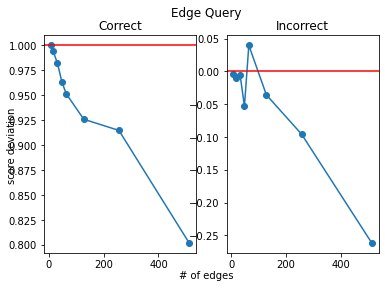

In [109]:
fig1, axs = plt.subplots(1,2)
fig1.suptitle('Edge Query')
fig1.text(0.5, 0.035, '# of edges', ha='center')
fig1.text(0.04, 0.5, 'score deviation', va='center', rotation='vertical')
axs[0].plot(edge_list,cor_edgeQ, marker = 'o')
axs[0].axhline(y=1, color = 'r', linestyle = '-')
axs[0].set_title('Correct')
axs[1].plot(edge_list,incor_edgeQ, marker = 'o')
axs[1].axhline(y=0, color = 'r', linestyle = '-')
axs[1].set_title('Incorrect')

Text(0.5, 1.0, 'Incorrect')

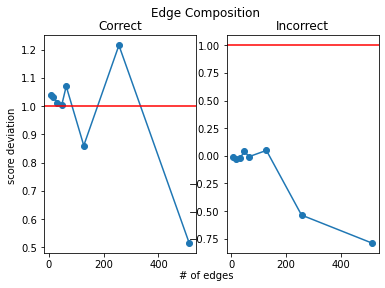

In [110]:
fig1, axs = plt.subplots(1,2)
fig1.suptitle('Edge Composition')
fig1.text(0.5, 0.035, '# of edges', ha='center')
fig1.text(0.04, 0.5, 'score deviation', va='center', rotation='vertical')
axs[0].plot(edge_list,cor_compQ, marker = 'o')
axs[0].axhline(y=1, color = 'r', linestyle = '-')
axs[0].set_title('Correct')
axs[1].plot(edge_list,incor_compQ, marker = 'o')
axs[1].axhline(y=1, color = 'r', linestyle = '-')
axs[1].set_title('Incorrect')

In [104]:
cor_edgeQ_R, incor_edgeQ_R, cor_compQ_R, incor_compQ_R = testing_R(vertex_dim, vertex_num, edge_list, num_trials)

Text(0.5, 1.0, 'Incorrect')

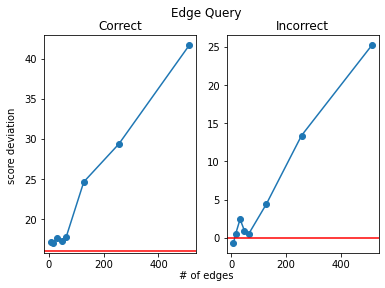

In [107]:
fig1, axs = plt.subplots(1,2)
fig1.suptitle('Edge Query')
fig1.text(0.5, 0.035, '# of edges', ha='center')
fig1.text(0.04, 0.5, 'score deviation', va='center', rotation='vertical')
axs[0].plot(edge_list,cor_edgeQ_R, marker = 'o')
axs[0].axhline(y=16, color = 'r', linestyle = '-')
axs[0].set_title('Correct')
axs[1].plot(edge_list,incor_edgeQ_R, marker = 'o')
axs[1].axhline(y=0, color = 'r', linestyle = '-')
axs[1].set_title('Incorrect')

Text(0.5, 1.0, 'Incorrect')

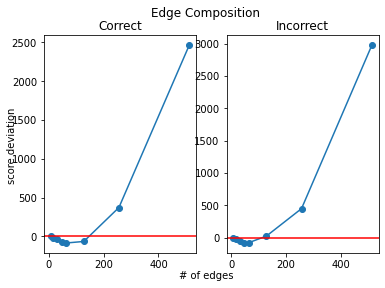

In [111]:
fig1, axs = plt.subplots(1,2)
fig1.suptitle('Edge Composition')
fig1.text(0.5, 0.035, '# of edges', ha='center')
fig1.text(0.04, 0.5, 'score deviation', va='center', rotation='vertical')
axs[0].plot(edge_list,cor_compQ_R, marker = 'o')
axs[0].axhline(y=1, color = 'r', linestyle = '-')
axs[0].set_title('Correct')
axs[1].plot(edge_list,incor_compQ_R, marker = 'o')
axs[1].axhline(y=1, color = 'r', linestyle = '-')
axs[1].set_title('Incorrect')

In [103]:
test_code = vertex_code_R(16,20)
generate_graph_R(test_code,40)

array([  2.,   2.,   4.,   4.,  10.,   2.,  -2.,  10., -10.,  16.,  -4.,
        -6.,  -4.,   6.,   2.,   4.])

In [84]:
def generate_graph_R(codebook, num_edges):
  n,d = codebook.shape[0], codebook.shape[1]
  graph = 0
  for i in range(num_edges):
    d_ix, c_ix = rand.randint(0,n-1), rand.randint(0,n-1)
    dom, cod = codebook[d_ix], codebook[c_ix]
    graph  = graph + (dom*cod)
  return(graph)

array([[ 1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,
         1.,  1.,  1.],
       [-1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,
         1., -1., -1.],
       [ 1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,
         1., -1., -1.],
       [-1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,
         1., -1.,  1.],
       [-1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
         1.,  1., -1.],
       [-1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
         1., -1., -1.],
       [ 1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,
         1., -1., -1.],
       [-1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
        -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        -1., -1.,  1.],
       [ 1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
        -1., -1.,  1.],
       [-1., -1., -1., -1.,  1

In [88]:
codebook = test_code

In [89]:
n,d = codebook.shape[0], codebook.shape[1]


In [97]:
graph = 0
for i in range(4):
  d_ix, c_ix = rand.randint(0,n-1), rand.randint(0,n-1)
  dom, cod = codebook[d_ix], codebook[c_ix]
  graph  = graph + (dom*cod)


In [92]:
  d_ix, c_ix = rand.randint(0,n-1), rand.randint(0,n-1)
  dom, cod = codebook[d_ix], codebook[c_ix]

In [98]:
graph

array([ 0.,  4.,  0., -2.,  0.,  2., -2.,  0.,  0.,  2.,  0.,  0.,  4.,
        2., -2., -2.])